In [81]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score, KFold, RepeatedKFold
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn import preprocessing
from sklearn import metrics
from xgboost import XGBClassifier
from sklearn.feature_selection import RFECV
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 500)
print('Libraries Imported')
import warnings
warnings.filterwarnings('ignore')

Libraries Imported


In [82]:
i_path = 'D:\\Data\\Box-Office-Forecasting'
m = pd.read_csv(os.path.join(i_path, 'movie-master-final.csv'), header=0, sep=';', engine='python', encoding= 'utf8')

#target_variable = 'revenue_range'; problem_type = 'MULTICLASS'
target_variable = 'is_profitable'; problem_type = 'BINARY'

# youtube_features = ['like_ratio', 'like_count', 'dislike_count', 'view_count', 'comment_count',
#                     'polarity_tb','w_polarity_tb', 'count_pos_tb', 'count_neg_tb', 'polarity_sia',
#                     'w_polarity_sia', 'count_pos_sia', 'count_neg_sia', 'polarity_avg',
#                     'w_polarity_avg', 'pos_neg_ratio', 'pos_neg_ratio_1', 'pos_neg_ratio_3',
#                     'pos_neg_ratio_5']
#youtube_features = ['like_ratio', 'view_count', 'polarity_sia', 'comment_count']
#youtube_features = ['like_ratio', 'view_count', 'w_polarity_avg', 'polarity_sia', 'pos_neg_ratio_5']
youtube_features = ['like_ratio', 'view_count', 'comment_count', 'w_polarity_avg', 'count_pos_tb',
                    'polarity_sia', 'pos_neg_ratio_5']

#general_features = ['mpaa', 'budget', 'seasonality', 'is_sequel', 'runtime', 'screen_count', 'genre', 'year']
#general_features = ['mpaa', 'budget', 'seasonality', 'is_sequel', 'runtime', 'screen_count', 'year']
#general_features = ['mpaa', 'seasonality', 'is_sequel', 'runtime','genre', 'year']
#general_features = ['budget', 'screen_count']
general_features = []

all_features = general_features + [target_variable] + youtube_features
data = m[all_features + ['movie_id']]
commented_movies = list(m[m.comment_count > 1000]['movie_id'])

In [83]:
# like_ratio column has some 'infinity' values, we replace them with one.
data = data.replace(np.Inf, 1)

# Factorize revenue_range to get numbers instead of labels
factor = pd.factorize(data[target_variable])
data[target_variable] = factor[0]
definitions = factor[1]

# Use LabelEncoder to convert textual classifications to numeric. We will use the same encoder later to convert them back.
encoder = preprocessing.LabelEncoder()
if 'mpaa' in all_features:
    data['mpaa'] = encoder.fit_transform(data['mpaa'].astype(str))
if 'genre' in all_features:
    data['genre'] = encoder.fit_transform(data['genre'].astype(str))

# second dataset for the movies with comment
data_c = data[data.movie_id.isin(commented_movies)]
data = data.drop('movie_id', 1)
data_c = data_c.drop('movie_id', 1)

In [84]:
# Split columns into independent/predictor variables vs dependent/response/outcome variable
X = np.array(data.drop([target_variable], 1))
y = np.array(data[target_variable])

X_c = np.array(data_c.drop([target_variable], 1))
y_c = np.array(data_c[target_variable])

### Exhaustive Grid Search

In [85]:
def plot_efs(efs):
    metric_dict = efs.get_metric_dict()

    fig = plt.figure(figsize=(15,5))
    k_feat = sorted(metric_dict.keys())
    avg = [metric_dict[k]['avg_score'] for k in k_feat]

    upper, lower = [], []
    for k in k_feat:
        upper.append(metric_dict[k]['avg_score'] +
                     metric_dict[k]['std_dev'])
        lower.append(metric_dict[k]['avg_score'] -
                     metric_dict[k]['std_dev'])

    plt.fill_between(k_feat,
                     upper,
                     lower,
                     alpha=0.3,
                     color='blue',
                     lw=1)

    plt.plot(k_feat, avg, color='blue', marker='o')
    plt.ylabel('Accuracy +/- Standard Deviation')
    plt.xlabel('Number of Features')
    feature_min = len(metric_dict[k_feat[0]]['feature_idx'])
    feature_max = len(metric_dict[k_feat[-1]]['feature_idx'])
    plt.xticks(k_feat, 
               [str(metric_dict[k]['feature_names']) for k in k_feat], 
               rotation=90)
    plt.show()

In [86]:
xgb = XGBClassifier(colsample_bytree=1.0, gamma=1, min_child_weight=1, subsample=0.8) # best params for xgb
rkf = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1) # 10-fold cv with 5 repetitions
feature_names = list(filter(lambda x: x != target_variable, all_features))

#### All movies

In [87]:
efs_all = EFS(xgb, 
              min_features=1,
              max_features=len(X[0]),
              scoring='accuracy',
              print_progress=True,
              n_jobs=-1,
              cv=rkf)
efs_all = efs_all.fit(X, y, custom_feature_names=feature_names)

Features: 127/127

In [88]:
print('Best accuracy score: %.4f' % efs_all.best_score_)
print('Best subset (indices):', efs_all.best_idx_)
print('Best subset (corresponding names):', efs_all.best_feature_names_)

Best accuracy score: 0.6276
Best subset (indices): (1, 4, 6)
Best subset (corresponding names): ('view_count', 'count_pos_tb', 'pos_neg_ratio_5')


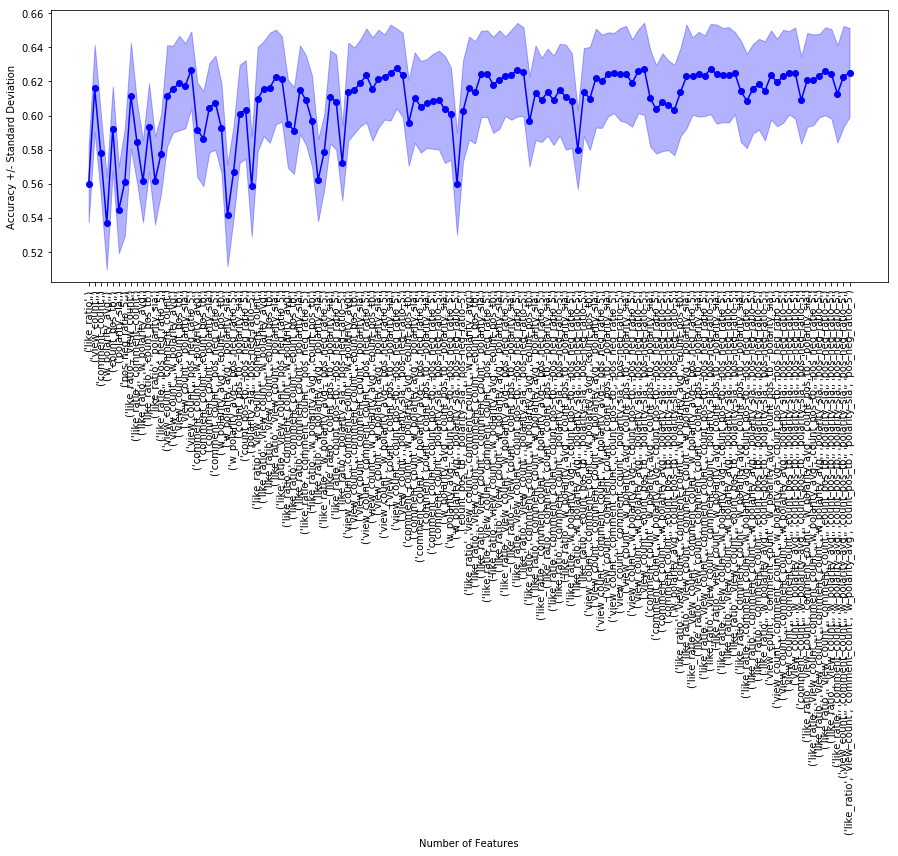

In [89]:
plot_efs(efs_all)

In [90]:
df_all = pd.DataFrame.from_dict(efs_all.get_metric_dict()).T
df_all.sort_values('avg_score', inplace=True, ascending=False)

In [91]:
file_name = "D:\\Master\\Thesis Related\\Results\\ExhaustedSearch_OnlyYoutube_{0}_All_Movies.xlsx".format(problem_type)
df_all.to_excel(file_name, encoding= 'utf8', header=True, index=True)

In [68]:
import pickle 
object = efs_all
filehandler = open("D:\\Master\\Thesis Related\\Results\\ExhaustedSearch_OnlyYoutube_{0}_Results_Object", 'wb') 
pickle.dump(object, filehandler)

#### Commented Movies

In [ ]:
efs_commented = EFS(xgb, 
                  min_features=7,
                  max_features=len(X_c[0]),
                  scoring='accuracy',
                  print_progress=True,
                  n_jobs=-1,
                  cv=rkf)
efs_commented = efs_commented.fit(X_c, y_c, custom_feature_names=feature_names)

print('Best accuracy score: %.4f' % efs_commented.best_score_)
print('Best subset (indices):', efs_commented.best_idx_)
print('Best subset (corresponding names):', efs_commented.best_feature_names_)

In [ ]:
plot_efs(efs_commented)

In [ ]:
df_commented = pd.DataFrame.from_dict(efs_commented.get_metric_dict()).T
df_commented.sort_values('avg_score', inplace=True, ascending=False)

In [ ]:
file_name = "D:\\Master\\Thesis Related\\Results\\ExhaustedSearch_FULL_{0}_Commented_Movies.xlsx".format(problem_type)
df_commented.to_excel(file_name, encoding= 'utf8', header=True, index=True)